# Chainer MNIST tutorial

http://docs.chainer.org/en/latest/tutorial/basic.html#example-multi-layer-perceptron-on-mnist

### Use model from Keras tutorial

https://elitedatascience.com/keras-tutorial-deep-learning-in-python

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

In [14]:
import numpy as np
np.random.seed(123)  # for reproducibility

### Load MNIST dataset

In [15]:
import os
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.
import gzip

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [16]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [17]:
type(X_train)

numpy.ndarray

In [18]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


In [22]:
import math

def plotSet(X,Y,N=0):
    if N==0:
        N = len(X)
    total = N
    if (len(X) < N):
        N = len(X)
    if (len(Y) < N):
        N = len(Y)
    max_in_row = 25
    M = 1
    if N > max_in_row:
        M = int(math.ceil(N/max_in_row))
        N = max_in_row
    w = math.floor(1/N*1000)/1000    
    #w=0.1
    h = math.floor(1/(M) *1000)/1000
    #h=0.3
    #print N,M,w,h
    pad = 0
    fig = plt.figure(figsize=(N/1.5, M), dpi=120)    
    for j in range(M):
        for i in range(N):
            n = i+(j*N)+1 
            if n > total:
                break
            l = pad+(i+1)*(w+pad)
            b = pad+(j)*(h+pad)
            #print n,l,b,Y[n-1]
            #a = fig.add_axes([l, b, w, h])
            a = fig.add_subplot(M,N,n)
            a.imshow(X[n-1][0])
            a.axis('off')
            a.set_title(str(Y[n-1]),fontsize=10)

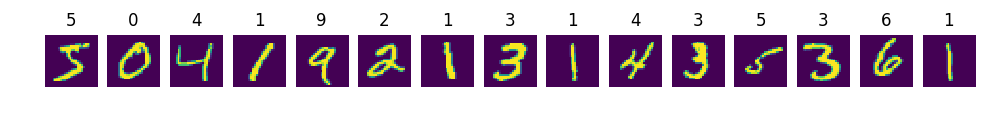

In [24]:
plotSet(X_train,y_train,15)

## Convert labels to 10 distinct class labels (one-hot)

In [25]:
print type(y_train[0])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print type(y_train[0])

<type 'numpy.uint8'>
<type 'numpy.int32'>


## Define model architecture

In [26]:
batchsize = 32
epoch = 12

In [27]:
# Model definition
class MLP(chainer.Chain):

    def __init__(self):
        super(MLP, self).__init__(
            l1 = L.Convolution2D(None, 32, (3,3)),
            l2 = L.Convolution2D(None, 32, (3,3)),
            l6 = L.Linear(None, 128),
            l8 = L.Linear(None, 10),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.max_pooling_2d(h2, (2,2))
        h4 = F.dropout(h3, 0.25)
        #print "H4 shape:", h4.shape
        h5 = F.reshape(h4,(h4.shape[0],h4.shape[1]*h4.shape[2]*h4.shape[3]))
        h6 = F.relu(self.l6(h5))
        h7 = F.dropout(h6, 0.5)
        h8 = F.softmax(self.l8(h7))
        return h8

In [29]:
from chainer.datasets import tuple_dataset
traning_dataset = tuple_dataset.TupleDataset(X_train, y_train)
test_dataset = tuple_dataset.TupleDataset(X_test, y_test)

# Training parameters

In [28]:
model = L.Classifier(MLP(), lossfun = F.softmax_cross_entropy)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [30]:
from chainer.training import extensions

train_iter = chainer.iterators.SerialIterator(traning_dataset, batchsize)
test_iter = chainer.iterators.SerialIterator(test_dataset, batchsize,
                                                 repeat=False, shuffle=False)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=".")
# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
    ['epoch',  'main/loss', 'validation/main/loss', 'main/accuracy','validation/main/accuracy', 'elapsed_time']))
# Save two plot images to the result dir
if extensions.PlotReport.available():
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy'],
                              'epoch', file_name='learning_curve.png'))

# Training

In [31]:
model.cleargrads()
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           1.54701     1.50536               0.91725        0.955871                  203.088       
2           1.50737     1.49751               0.954317       0.964058                  396.947       
3           1.49966     1.49447               0.961783       0.966454                  615.471       
4           1.49632     1.49325               0.964783       0.967352                  840.63        
5           1.49339     1.49209               0.96775        0.96905                   1089.9        
6           1.49215     1.49303               0.968933       0.968051                  1331.49       
7           1.49059     1.49546               0.97055        0.965755                  1574.83       
8           1.48818     1.49271               0.9729         0.968351                  1813.04       
9           1.48798     1.49079               0.97305        0.970048               

# Test predictions

In [33]:
def decodeNum(x):
    i = []
    for xi in x:
        ni = np.argmax(xi)
        i.append(ni)
    return i

Have 3 errors
9 ≠ 4
8 ≠ 9
3 ≠ 5


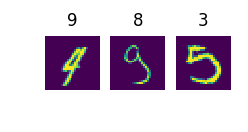

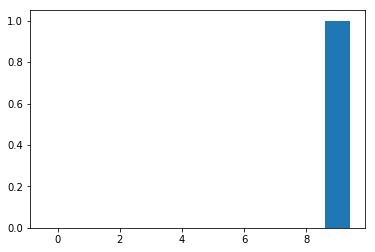

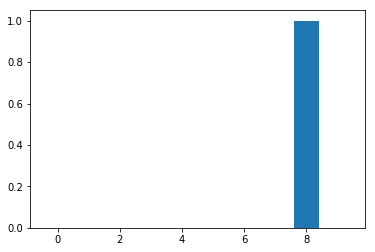

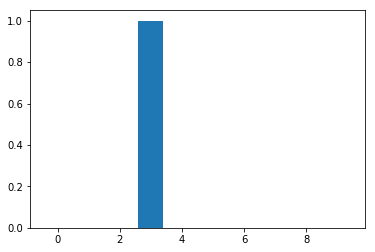

In [38]:
# Pick random indexes
test_indexes = np.random.randint(0,y_test.shape[0], batchsize)
x = X_test[test_indexes]
t = y_test[test_indexes]

# Predictions for random elements
y = model.predictor(x)
y = y.data
# y has predictions as probabilities
h = np.asarray(decodeNum(y))
# h has predictions as numbers

# Find incorrect predictions
errors = []
for i in range(len(h)):
    if h[i] != t[i]:        
        errors.append(i)
print "Have",len(errors),"errors"
# errors has indexes of incorrect redictions
for i in errors:
    print h[i],"≠", t[i]

# plot images and predictions (incorrect)
if len(errors) > 0:
    plotSet(x[errors],h[errors])

    # Plot probabilities
    y_err = y[errors]
    for i in range(len(y_err)):
        fig = plt.figure()
        plt.bar(range(len(y_err[i])), y_err[i])